In [93]:
import pandas as pd
import numpy as np
import time
import tqdm
pd.options.display.max_columns = None
pd.options.display.max_rows= 2000
import datetime
from sqlalchemy import create_engine
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [5]:
avs_products['uq_customer_id'] = np.where(avs_products.ferdi_grup_tanim == 'GRUP', avs_products.katilimci_uq_id, avs_products.odeyen_uq_id)

In [6]:
# Creating soz_prefix column
avs_products.soz_pol_no = avs_products.soz_pol_no.astype('str')
avs_products['soz_prefix'] = avs_products.soz_pol_no + str('_') + avs_products.prefiks
avs_products.drop(['soz_pol_no', 'prefiks'], axis=1, inplace=True)

In [7]:
# Converting the date columns into date-time
avs_products["baslangic_tar"] = pd.to_datetime(avs_products.baslangic_tar)
avs_products["iptal_tar"] = pd.to_datetime(avs_products.iptal_tar)
avs_products["bitis_tar"] = pd.to_datetime(avs_products.bitis_tar, errors = 'coerce')

In [8]:
# Extracting Year_Month columns
avs_products['Bas_Tar_Year_Month'] = avs_products.baslangic_tar.dt.year*100 + avs_products.baslangic_tar.dt.month
avs_products['Iptal_Tar_Year_Month'] = avs_products.iptal_tar.dt.year*100 + avs_products.iptal_tar.dt.month
avs_products['Bit_Tar_Year_Month'] = avs_products.bitis_tar.dt.year*100 + avs_products.bitis_tar.dt.month

In [9]:
years=[  201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 
         201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001,
         202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102,
         202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111, 202112
      ]

In [55]:
police_sayısı_df_all = pd.DataFrame(index=list(avs_products['uq_customer_id'].unique()), columns=["dummy"], data=np.zeros(shape=(len(avs_products['uq_customer_id'].unique()), 1)))

In [ ]:
police_sayısı_df_all.head()

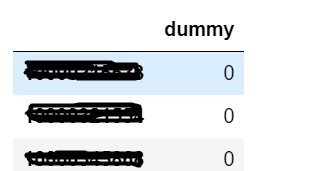

In [57]:
# Calculating number of soz_prefix per customer for each year and writing to dataframe as a column
for col in tqdm.tqdm(years):
    temp_df = avs_products[(avs_products['Bas_Tar_Year_Month'] < col) & ((avs_products['Iptal_Tar_Year_Month'] > col) | ((avs_products['Bit_Tar_Year_Month'] > col)))]
    temp_df_cust = temp_df.groupby(["uq_customer_id"])['soz_prefix'].count()
    police_sayısı_df_all = police_sayısı_df_all.join(temp_df_cust)
    police_sayısı_df_all = police_sayısı_df_all.rename( columns={'soz_prefix': str(col)} )

100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


In [58]:
police_sayısı_df_all.fillna(0, inplace=True)
police_sayısı_df_all.drop('dummy', axis=1, inplace=True)

In [ ]:
police_sayısı_df_all.head(3)

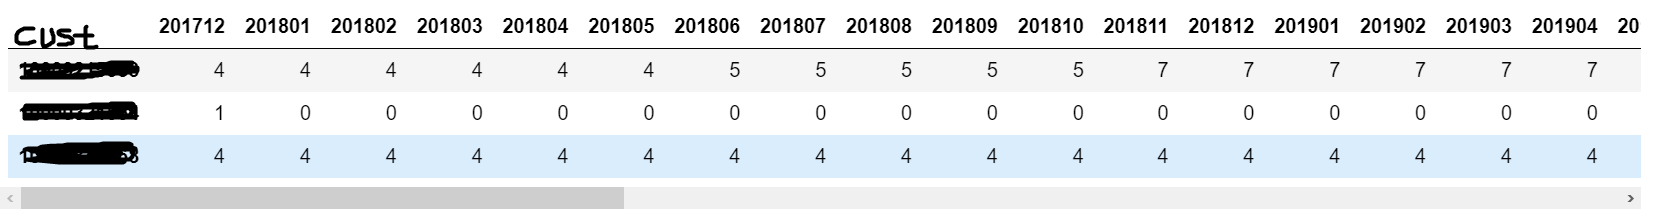

In [60]:
# Max and Min values of years for each customer
police_sayısı_df_all['max_number_police'] = police_sayısı_df_all.apply(lambda x : x.max(), axis=1)
police_sayısı_df_all['min_number_police'] = police_sayısı_df_all.apply(lambda x : x.min(), axis=1)

In [61]:
# Max ve Min değere eşit olan yıllardan en sondakini almak için, index[-2] diyoruz, çünkü max değere eşit olan sütunun kendisi de var .
# Max ve Min değeri aynı olan müşterilerde ise 'max_number_police' yazıyor bu düzeltilecek ilerde
# Max ve Min değere sahip kaç tane ay var hesaplamak için de len -1 diyoruz aynı sebepten ötürü
police_sayısı_df_all['last_max_police_time']   = police_sayısı_df_all.apply(lambda x : x[x==x['max_number_police']].index[-2], axis=1)
police_sayısı_df_all['last_min_police_time']   = police_sayısı_df_all.apply(lambda x : x[x==x['min_number_police']].index[-2], axis=1)

police_sayısı_df_all['stay_max_police_months'] = police_sayısı_df_all.apply(lambda x : len(x[x==x['max_number_police']]) - 1, axis=1)
police_sayısı_df_all['stay_min_police_months'] = police_sayısı_df_all.apply(lambda x : len(x[x==x['min_number_police']]) - 1, axis=1)

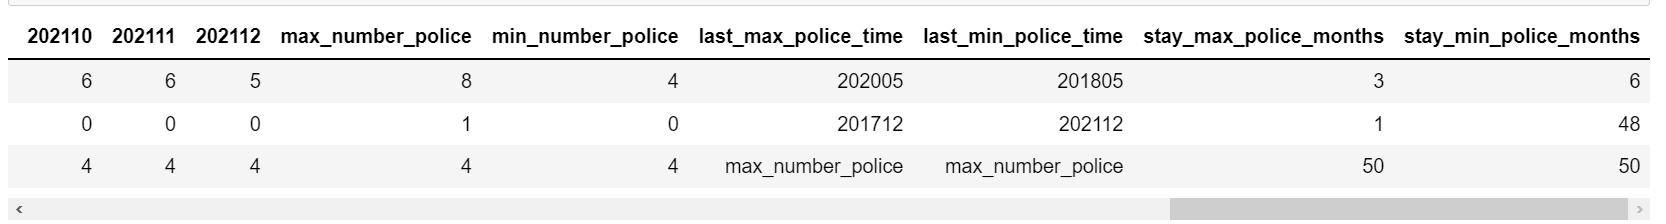

In [63]:
# replace the string value in last_max_police_time and last_min_police_time 
police_sayısı_df_all['last_max_police_time'] = police_sayısı_df_all['last_max_police_time'].replace("max_number_police", None)
police_sayısı_df_all['last_min_police_time'] = police_sayısı_df_all['last_min_police_time'].replace("max_number_police", None)

In [65]:
# Police sayısı bir ÖNCEKİ aya göre artan veya azalan customer_id leri belirleyip, her customer_id için totalde kaç artış azalış var hesaplayan script
police_sayısı_df_all['police_sayısı_artis_toplami'] = 0
police_sayısı_df_all['police_sayısı_azalis_toplami'] = 0
for idx in range(len(years[:-1])):
    temp_df = police_sayısı_df_all[str(years[idx+1])] - police_sayısı_df_all[str(years[idx])]
    artis_ids = list(temp_df[temp_df > 0].index)
    azalis_ids = list(temp_df[temp_df < 0].index)
    police_sayısı_df_all.loc[artis_ids, "police_sayısı_artis_toplami"] = police_sayısı_df_all.loc[artis_ids, "police_sayısı_artis_toplami"] + 1
    police_sayısı_df_all.loc[azalis_ids, "police_sayısı_azalis_toplami"] = police_sayısı_df_all.loc[azalis_ids, "police_sayısı_azalis_toplami"] + 1



# Police sayısı bir SONRAKİ aya göre artan veya azalan customer_id leri belirleyip, her customer_id için totalde kaç artış azalış var hesaplayan script
# reversed() range aralığını tersten dizer (0,48) için [47,46,45....]
police_sayısı_df_all['police_sayısı_last_artis_toplami'] = 0
police_sayısı_df_all['police_sayısı_last_azalis_toplami'] = 0
for idx in reversed(range(len(years[1:]))):
    temp_df = police_sayısı_df_all[str(years[idx-1])] - police_sayısı_df_all[str(years[idx])]
    artis_ids = list(temp_df[temp_df > 0].index)
    azalis_ids = list(temp_df[temp_df < 0].index)
    police_sayısı_df_all.loc[artis_ids, "police_sayısı_last_artis_toplami"] = police_sayısı_df_all.loc[artis_ids, "police_sayısı_last_artis_toplami"] + 1
    police_sayısı_df_all.loc[azalis_ids, "police_sayısı_last_azalis_toplami"] = police_sayısı_df_all.loc[azalis_ids, "police_sayısı_last_azalis_toplami"] + 1
    if idx % 3 == 0:
        month_count = len(years) - idx
        police_sayısı_df_all['police_sayısı_artis_last_{}_months'.format(month_count)] = police_sayısı_df_all['police_sayısı_last_artis_toplami']
        police_sayısı_df_all['police_sayısı_azalis_last_{}_months'.format(month_count)] = police_sayısı_df_all['police_sayısı_last_azalis_toplami']

In [ ]:
police_sayısı_df_all.head(3)

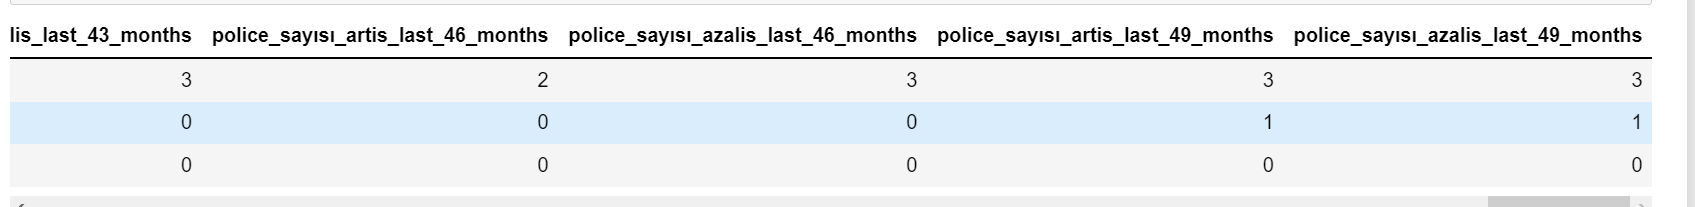

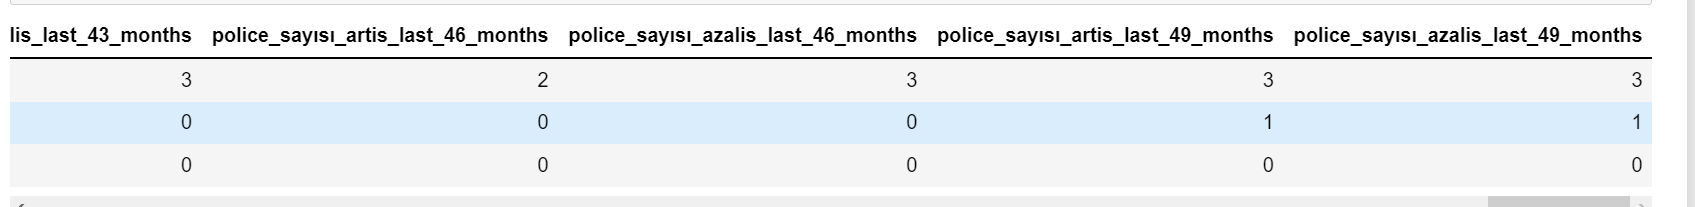

In [86]:
temp_df = police_sayısı_df_all.copy()

In [87]:
temp_df['last_max_police_time'] = datetime.datetime(year=2022, month=1, day=1) - pd.to_datetime(temp_df['last_max_police_time'], format="%Y%m")
temp_df['last_min_police_time'] = datetime.datetime(year=2022, month=1, day=1) - pd.to_datetime(temp_df['last_min_police_time'], format="%Y%m")

In [88]:
temp_df['last_max_police_time'] = temp_df['last_max_police_time'].astype(str).str.replace(" days", "").astype(int)
temp_df['last_min_police_time'] = temp_df['last_min_police_time'].astype(str).str.replace(" days", "").astype(int)

In [89]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

str_columns = [str(x) for x in years]

for i in [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]:
    temp_df['last_{}_months_avg'.format(i)] = temp_df[str_columns[-i:]].mean(axis=1)

In [ ]:
temp_df.head(3)

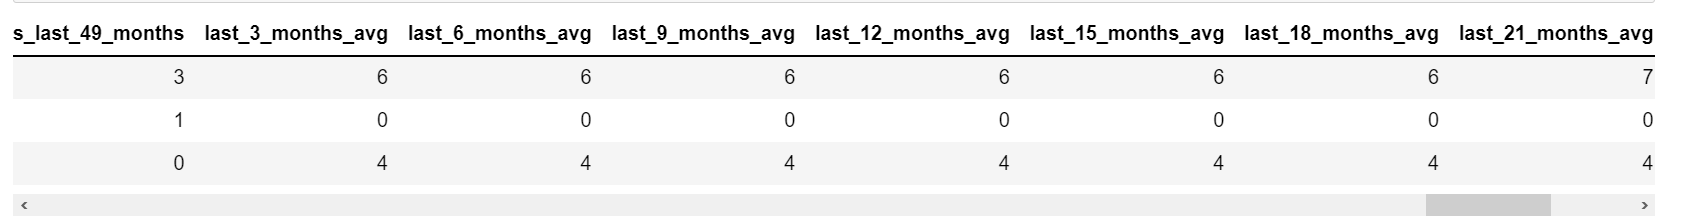

In [91]:
final_temp_df = temp_df.copy()
final_temp_df = final_temp_df.reset_index()

In [92]:
final_temp_df = final_temp_df.rename(columns= {"index": "uq_customer_id"} )